In [1]:
# import libraies
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import RMSprop



In [2]:
# loading dateset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()


In [3]:
# check the number of train images
train_images.shape


(50000, 32, 32, 3)

In [4]:
# check the number of test images
test_images.shape


(10000, 32, 32, 3)

In [5]:
# constructing the model
model = tf.keras.models.Sequential([
        # create convolution kernel
        tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                            input_shape=(32, 32, 3)),
        # create maxpooling layer
        tf.keras.layers.MaxPooling2D(2, 2),
        # repeating process
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        # flatten the tensor to 1d 
        tf.keras.layers.Flatten(),
        # the second layer
        tf.keras.layers.Dense(128, activation='relu'),
        # the final layer, since we have multiple classes, we use softmax instead of simoid
        tf.keras.layers.Dense(10, activation='softmax')
])


In [6]:
# check if the model is constructed correctly
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 64)         0

In [7]:
# compiling the model
model.compile(loss=tf.losses.sparse_categorical_crossentropy,
              optimizer=RMSprop(learning_rate=0.001), metrics=['acc'])


In [8]:
# start training
history = model.fit(
          # normalizing the images by /255
          train_images/255,
          train_labels,
          epochs=10,
          validation_data=(test_images/255, test_labels)
)


Epoch 1/10
1563/1563 [==============================] - 32s 20ms/step - loss: 1.5928 - acc: 0.4229 - val_loss: 1.3584 - val_acc: 0.5007
Epoch 2/10
1563/1563 [==============================] - 29s 19ms/step - loss: 1.2251 - acc: 0.5648 - val_loss: 1.1654 - val_acc: 0.5834
Epoch 3/10
1563/1563 [==============================] - 30s 19ms/step - loss: 1.0689 - acc: 0.6254 - val_loss: 1.0311 - val_acc: 0.6376
Epoch 4/10
1563/1563 [==============================] - 30s 19ms/step - loss: 0.9696 - acc: 0.6604 - val_loss: 1.0239 - val_acc: 0.6486
Epoch 5/10
1563/1563 [==============================] - 30s 19ms/step - loss: 0.9004 - acc: 0.6879 - val_loss: 1.1655 - val_acc: 0.6093
Epoch 6/10
1563/1563 [==============================] - 29s 19ms/step - loss: 0.8437 - acc: 0.7054 - val_loss: 1.1091 - val_acc: 0.6290
Epoch 7/10
1563/1563 [==============================] - 30s 19ms/step - loss: 0.7988 - acc: 0.7217 - val_loss: 0.9670 - val_acc: 0.6648
Epoch 8/10
1563/1563 [==========================

In [9]:
# start classifying

# the different classes
name = ["airplane", "automobile", "bird", "cat",
        "deer", "dog", "frog", "horse", "ship", "truck"]
# getting the image path the user wants to classify
file_path = input("Enter the path for the image you want to classify:")
img = image.load_img(file_path, target_size=(32, 32))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
classes = model.predict(images, batch_size=20)
# print the result
print("It's a "+name[np.argmax(classes[0])]+".")


It's a ship.


Text(0.5, 1.0, 'Training and validation loss')

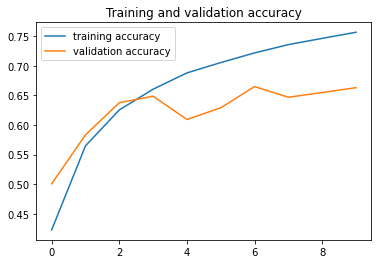

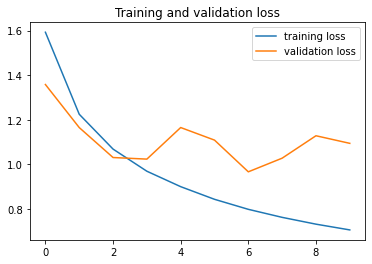

In [15]:
# drawing the graph

# getting the accuacy value
acc = history.history['acc']
val_acc = history.history['val_acc']
# getting the loss value
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
# plotting the graph
plt.plot(epochs, acc, label='training accuracy')
plt.plot(epochs, val_acc, label='validation accuracy')
plt.legend()
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.legend()
plt.title('Training and validation loss')
